## Multi class USPS

In [1]:
import sys
sys.path.insert(0, '..')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from activation import TanH, Sigmoid, ReLU, Softmax
from enums import GradientDescentMode
from linear import Linear
from loss import MSELoss, CELoss
from sequential import Sequential
from optimizers import SGD
from utils import onehot_encoding

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
plt.style.use('seaborn-whitegrid')

#### USPS

In [4]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp = list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest")

In [5]:
usps_train_val_x, usps_train_val_y = load_usps("data/USPS_train.txt")
usps_train_x, usps_val_x, usps_train_y, usps_val_y = train_test_split(usps_train_val_x, usps_train_val_y, test_size=.2, random_state=42)
usps_test_x, usps_test_y = load_usps("data/USPS_test.txt")
print('Train shape :', usps_train_x.shape, usps_train_y.shape)
print('Validation shape :', usps_val_x.shape, usps_val_y.shape)
print('Test shape :', usps_test_x.shape, usps_test_y.shape)

Train shape : (5832, 256) (5832,)
Validation shape : (1459, 256) (1459,)
Test shape : (2007, 256) (2007,)


In [6]:
usps_train_onehot_y = onehot_encoding(usps_train_y, 10)
usps_val_onehot_y = onehot_encoding(usps_val_y, 10)
usps_test_onehot_y = onehot_encoding(usps_test_y, 10)
print('One hot train :', usps_train_onehot_y.shape)
print('One hot val :', usps_val_onehot_y.shape)
print('One hot test :', usps_test_onehot_y.shape)

One hot train : (5832, 10)
One hot val : (1459, 10)
One hot test : (2007, 10)


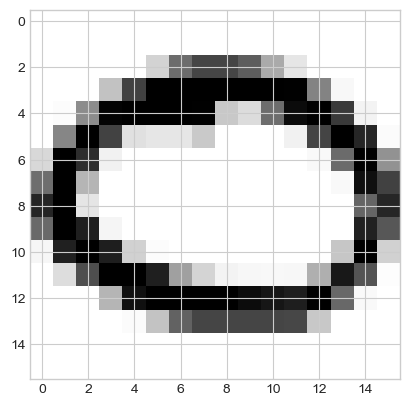

In [8]:
show_usps(usps_train_x[-1])

In [8]:
def eval_fn(net, X_test, y_test):
    y_pred = net(X_test).argmax(1)
    y_test = y_test.argmax(1)
    return np.mean(y_pred == y_test)

#### Linear - TanH - Linear - TanH - Linear - Softmax - MSELoss

In [9]:
net = Sequential(
    Linear(256, 100),
    TanH(),
    Linear(100, 100),
    TanH(),
    Linear(100, 10),
    Softmax()
)

loss = MSELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    1e-2,
    usps_train_x,
    usps_train_onehot_y,
    10_000,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    usps_val_x,
    usps_val_onehot_y
)

Train : -----------------------------------
Epoch 1000: train loss: 0.028388772609178724 val loss: 0.028109199062829104 val eval_fn: 0.8320767649074708
Epoch 2000: train loss: 0.015638718761610597 val loss: 0.01605282694097914 val eval_fn: 0.910212474297464
Epoch 3000: train loss: 0.011820893547420453 val loss: 0.012530949574208495 val eval_fn: 0.9314599040438657
Epoch 4000: train loss: 0.009947802755251426 val loss: 0.010900344394272517 val eval_fn: 0.9362577107607951
Epoch 5000: train loss: 0.008768912437866939 val loss: 0.009950997842106311 val eval_fn: 0.9410555174777244
Epoch 6000: train loss: 0.007920022989689465 val loss: 0.009314184122866631 val eval_fn: 0.9424263193968472
Epoch 7000: train loss: 0.007258099432666 val loss: 0.008845798914370972 val eval_fn: 0.9458533241946538
Epoch 8000: train loss: 0.006716909122052478 val loss: 0.00848053372204065 val eval_fn: 0.9479095270733379
Epoch 9000: train loss: 0.006260492703834651 val loss: 0.008184215224227102 val eval_fn: 0.9506511

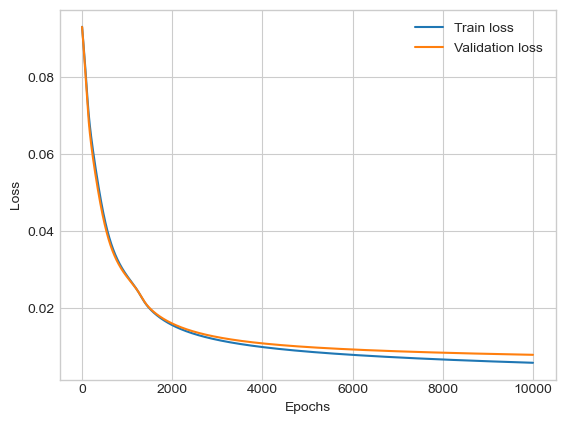

In [10]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

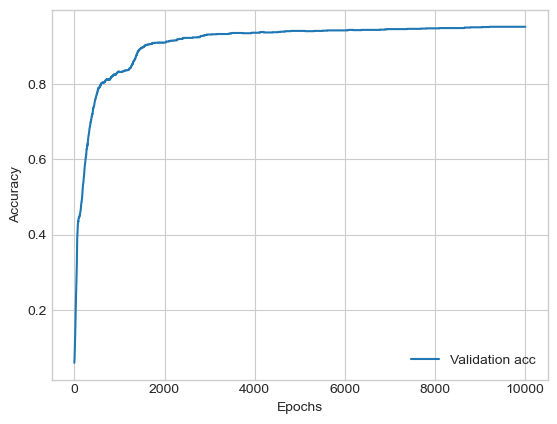

In [11]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, usps_test_x, usps_test_onehot_y))

Test acc : 0.9103139013452914


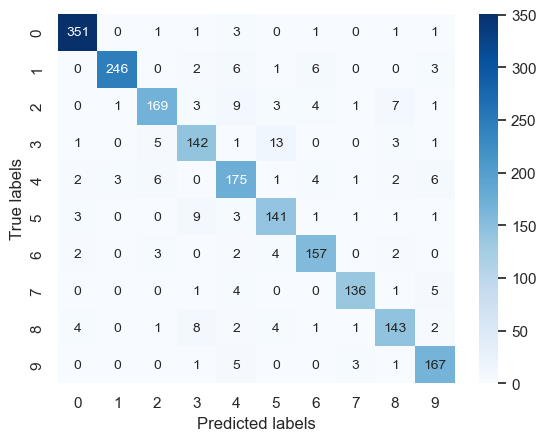

In [16]:
y_pred = net(usps_test_x).argmax(1)
y_test = usps_test_onehot_y.argmax(1)
cm = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g') # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#### Learning rate

In [17]:
lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1]
n_epochs = 5_000

all_loss_ = []
all_loss_valid_ = []
all_acc_valid_ = []
all_acc_test_ = []

for lr in lrs:
    print('Learning rate :', lr)
    net = Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    )
    loss = MSELoss()

    all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
        net,
        loss,
        lr,
        usps_train_x,
        usps_train_onehot_y,
        n_epochs,
        GradientDescentMode.BATCH,
        -1,
        eval_fn,
        usps_val_x,
        usps_val_onehot_y
    )

    net.set_parameters(best_parameters)
    acc_test = eval_fn(net, usps_test_x, usps_test_onehot_y)
    print('Test acc :', acc_test)

    all_loss_.append(all_loss)
    all_loss_valid_.append(all_loss_valid)
    all_acc_valid_.append(all_acc_valid)
    all_acc_test_.append(acc_test)
    print()

Learning rate : 0.0001
Train : -----------------------------------
Epoch 500: train loss: 0.08920798219058002, validation loss: 0.08897755993578536, validation accuracy: 0.1864290610006854
Epoch 1000: train loss: 0.08865063189438989, validation loss: 0.08838825080530117, validation accuracy: 0.20013708019191226
Epoch 1500: train loss: 0.08806976964047573, validation loss: 0.08777196249534859, validation accuracy: 0.2213845099383139
Epoch 2000: train loss: 0.08746331850351009, validation loss: 0.08712653167982042, validation accuracy: 0.2556545579163811
Epoch 2500: train loss: 0.08682933767602372, validation loss: 0.08644994889018355, validation accuracy: 0.27553118574366003
Epoch 3000: train loss: 0.08616609446816621, validation loss: 0.08574043783266483, validation accuracy: 0.295407813570939
Epoch 3500: train loss: 0.08547216771288335, validation loss: 0.08499656730167406, validation accuracy: 0.3139136394790953
Epoch 4000: train loss: 0.08474658987482768, validation loss: 0.08421740

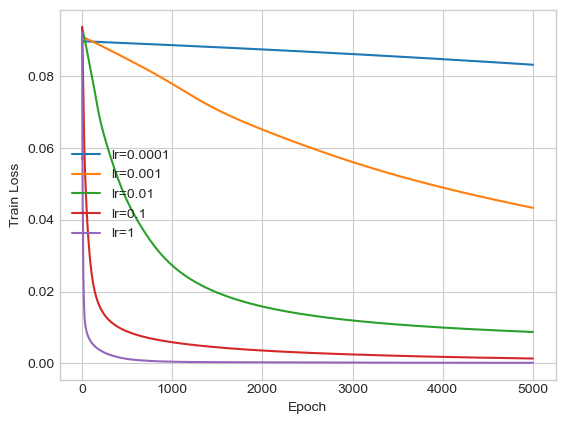

In [19]:
# lr loss
plt.figure()
for i, lr in enumerate(lrs):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

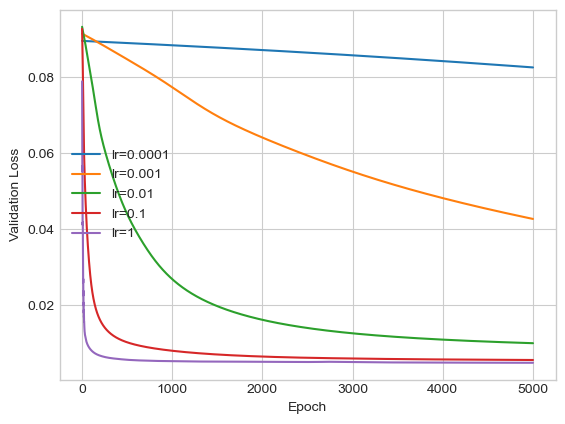

In [20]:
# lr valid loss
plt.figure()
for i, lr in enumerate(lrs):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_valid_[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

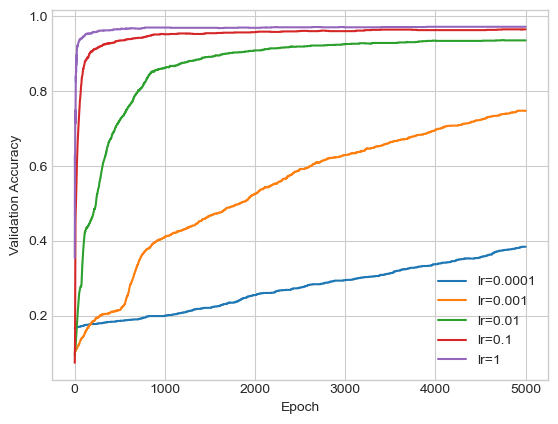

In [22]:
# lr valid accuracy
plt.figure()
for i, lr in enumerate(lrs):
    plt.plot(np.arange(1, 1 + n_epochs), all_acc_valid_[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

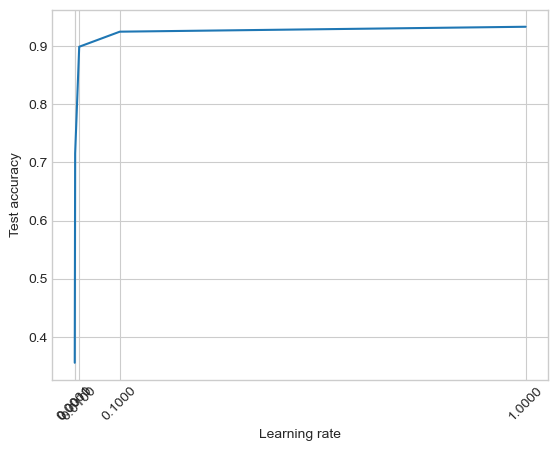

In [23]:
# lr test accuracy
plt.figure()
plt.plot(lrs, all_acc_test_)
plt.xlabel('Learning rate')
plt.ylabel('Test accuracy')
plt.xticks(lrs, rotation=45)
plt.show()

#### Activations

In [24]:
nets = {
    'relu' : Sequential(
        Linear(256, 100),
        ReLU(),
        Linear(100, 100),
        ReLU(),
        Linear(100, 10),
        Softmax()
    ),
    'tanh' : Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ),
    'sigmoid': Sequential(
        Linear(256, 100),
        Sigmoid(),
        Linear(100, 100),
        Sigmoid(),
        Linear(100, 10),
        Softmax()
    ),
    'relu-tanh': Sequential(
        Linear(256, 100),
        ReLU(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ),
    'relu-sigmoid': Sequential(
        Linear(256, 100),
        ReLU(),
        Linear(100, 100),
        Sigmoid(),
        Linear(100, 10),
        Softmax()
    ),
    'tanh-relu': Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        ReLU(),
        Linear(100, 10),
        Softmax()
    ),
    'tanh-sigmoid': Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        Sigmoid(),
        Linear(100, 10),
        Softmax()
    ),
    'sigmoid-relu': Sequential(
        Linear(256, 100),
        Sigmoid(),
        Linear(100, 100),
        ReLU(),
        Linear(100, 10),
        Softmax()
    ),
    'sigmoid-tanh': Sequential(
        Linear(256, 100),
        Sigmoid(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    )
}

In [25]:
lr = 1e-1
n_epochs = 5_000

all_loss_ = []
all_loss_valid_ = []
all_acc_valid_ = []
all_acc_test_ = []

for activations_names, net in nets.items():
    print('Activations :', activations_names)
 
    loss = MSELoss()
    all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
        net,
        loss,
        lr,
        usps_train_x,
        usps_train_onehot_y,
        n_epochs,
        GradientDescentMode.BATCH,
        -1,
        eval_fn,
        usps_val_x,
        usps_val_onehot_y
    )

    net.set_parameters(best_parameters)
    acc_test = eval_fn(net, usps_test_x, usps_test_onehot_y)
    print('Test acc :', acc_test)

    all_loss_.append(all_loss)
    all_loss_valid_.append(all_loss_valid)
    all_acc_valid_.append(all_acc_valid)
    all_acc_test_.append(acc_test)
    print()

Activations : relu
Train : -----------------------------------
Epoch 500: train loss: 0.007229471825020143, validation loss: 0.009036135398215175, validation accuracy: 0.9410555174777244
Epoch 1000: train loss: 0.005112064949845554, validation loss: 0.007811219672380295, validation accuracy: 0.9506511309115833
Epoch 1500: train loss: 0.0039535389572771225, validation loss: 0.007261475423229314, validation accuracy: 0.95407813570939
Epoch 2000: train loss: 0.003162769097942189, validation loss: 0.006864488768085902, validation accuracy: 0.9554489376285127
Epoch 2500: train loss: 0.002623931985877611, validation loss: 0.0066517192981369695, validation accuracy: 0.9561343385880741
Epoch 3000: train loss: 0.002137006640977464, validation loss: 0.00660530029111825, validation accuracy: 0.9588759424263193
Epoch 3500: train loss: 0.0019298661204307289, validation loss: 0.006670075140360148, validation accuracy: 0.9554489376285127
Epoch 4000: train loss: 0.001607990151643599, validation loss: 

In [35]:
activations_names = list(nets.keys())
print(activations_names[0])

relu


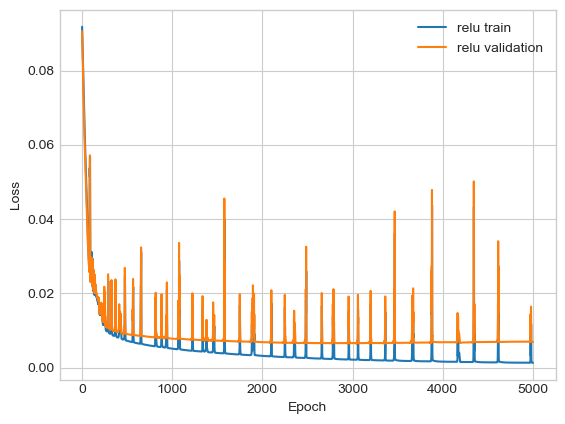

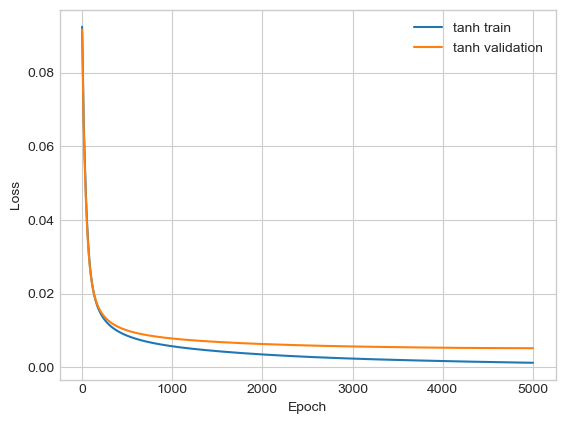

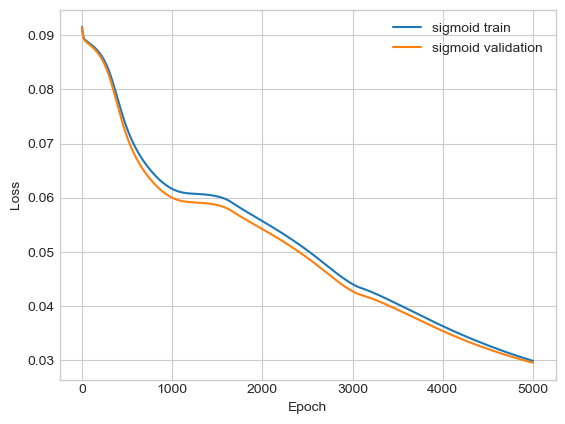

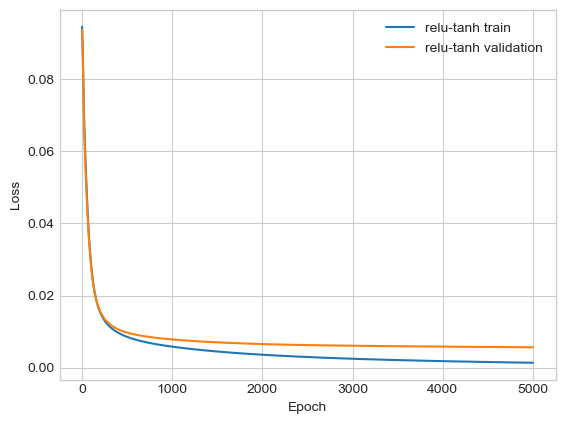

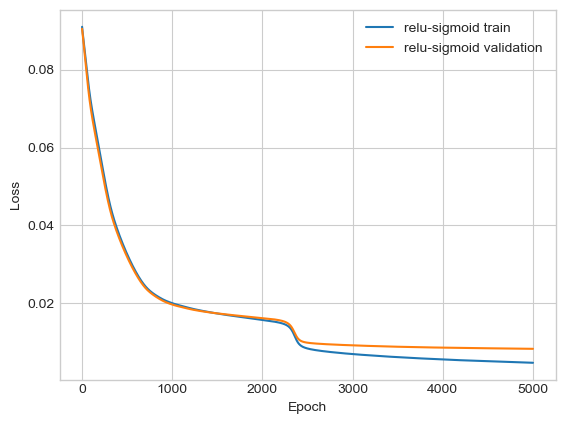

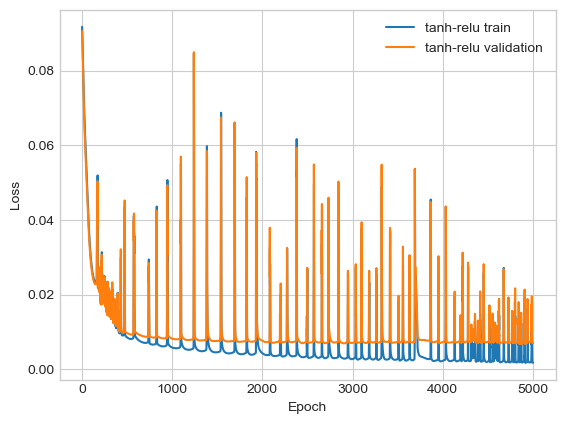

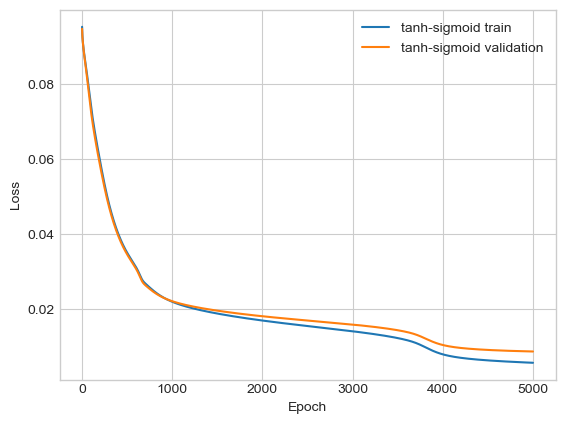

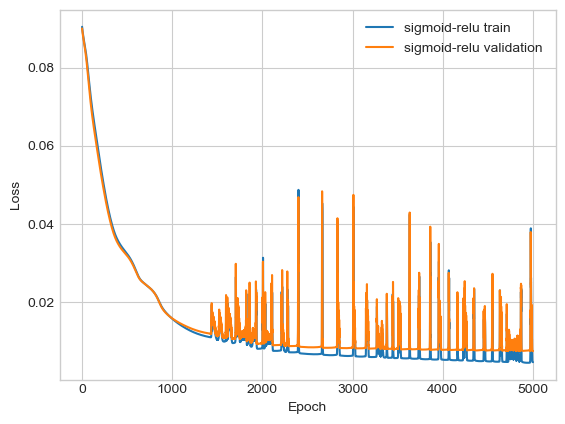

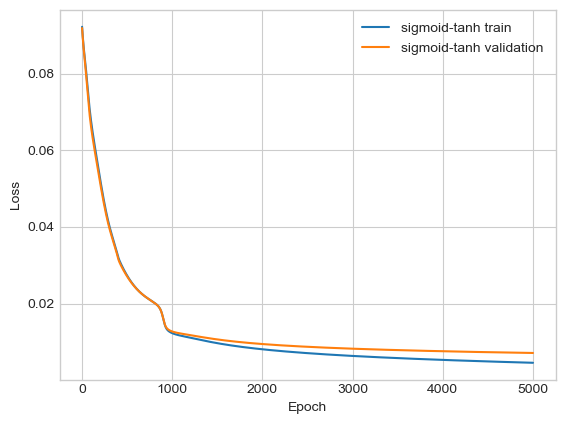

In [39]:
for i in range(len(activations_names)):
    plt.figure()
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_[i], label=f'{activations_names[i]} train')
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_valid_[i], label=f'{activations_names[i]} validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

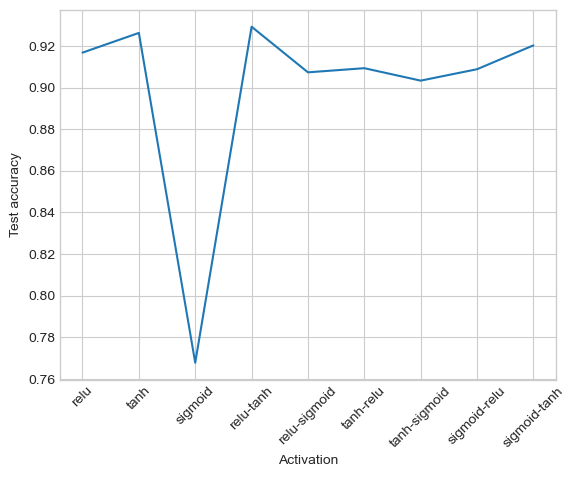

In [41]:
# activations test accuracy
plt.figure()
plt.plot(activations_names, all_acc_test_)
plt.xlabel('Activation')
plt.ylabel('Test accuracy')
plt.xticks(activations_names, rotation=45)
plt.show()

#### N hidden layers

In [43]:
nets = [
    Sequential(
        Linear(256, 10),
        Softmax()
    ),
    Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ),
    Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ),
    Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ),
    Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ),   
    Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 100),
        TanH(),
        Linear(100, 10),
        Softmax()
    ), 
]

In [44]:
lr = 1e-1
n_epochs = 5_000

all_loss_ = []
all_loss_valid_ = []
all_acc_valid_ = []
all_acc_test_ = []

for i, net in enumerate(nets):
    print('N hidden layers :', i)
 
    loss = MSELoss()
    all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
        net,
        loss,
        lr,
        usps_train_x,
        usps_train_onehot_y,
        n_epochs,
        GradientDescentMode.BATCH,
        -1,
        eval_fn,
        usps_val_x,
        usps_val_onehot_y
    )

    net.set_parameters(best_parameters)
    acc_test = eval_fn(net, usps_test_x, usps_test_onehot_y)
    print('Test acc :', acc_test)

    all_loss_.append(all_loss)
    all_loss_valid_.append(all_loss_valid)
    all_acc_valid_.append(all_acc_valid)
    all_acc_test_.append(acc_test)
    print()

N hidden layers : 0
Train : -----------------------------------
Epoch 500: train loss: 0.010524058682628757, validation loss: 0.011126325071595809, validation accuracy: 0.9328307059629883
Epoch 1000: train loss: 0.00839608774351831, validation loss: 0.009604999664136483, validation accuracy: 0.9383139136394791
Epoch 1500: train loss: 0.007404979904238835, validation loss: 0.008975317378395103, validation accuracy: 0.9431117203564084
Epoch 2000: train loss: 0.006778077265828185, validation loss: 0.008613106807269162, validation accuracy: 0.9437971213159698
Epoch 2500: train loss: 0.006327282549646564, validation loss: 0.008372938835879388, validation accuracy: 0.9465387251542152
Epoch 3000: train loss: 0.005978782449824932, validation loss: 0.008199460028278207, validation accuracy: 0.9458533241946538
Epoch 3500: train loss: 0.005696121365273117, validation loss: 0.008067267933951235, validation accuracy: 0.9465387251542152
Epoch 4000: train loss: 0.005459252902494302, validation loss: 

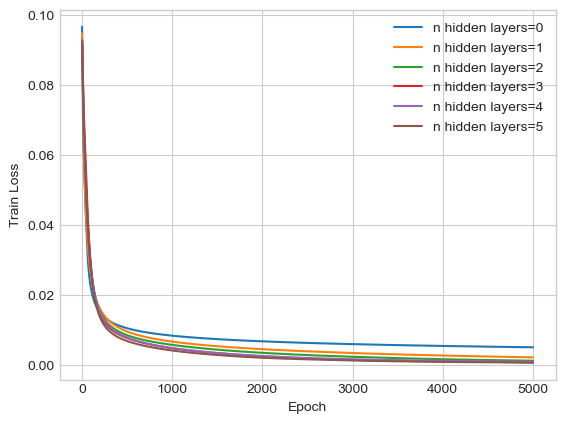

In [45]:
# n hidden layers loss
plt.figure()
for i in range(len(nets)):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_[i], label=f'n hidden layers={i}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

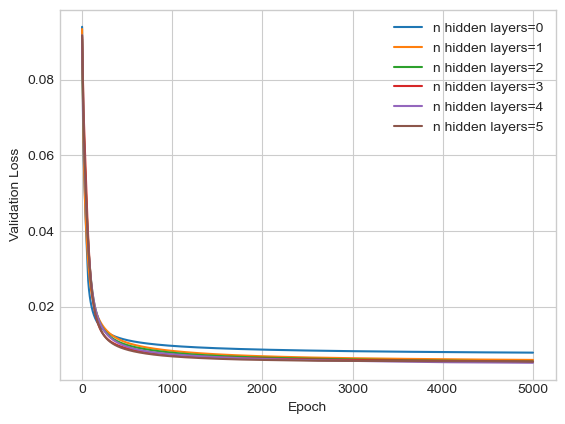

In [46]:
# n hidden layers validation loss
plt.figure()
for i in range(len(nets)):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_valid_[i], label=f'n hidden layers={i}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

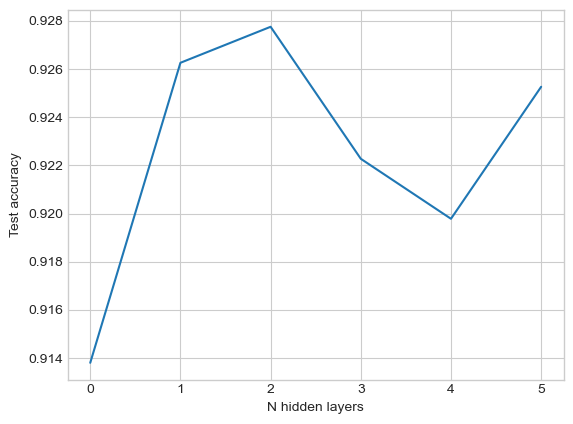

In [49]:
# n hidden layers test accuracy
plt.figure()
plt.plot(range(len(nets)), all_acc_test_)
plt.xlabel('N hidden layers')
plt.ylabel('Test accuracy')
plt.xticks(range(len(nets)))
plt.show()

#### Cross Entropy Loss

In [17]:
net = Sequential(
    Linear(256, 100),
    TanH(),
    Linear(100, 100),
    TanH(),
    Linear(100, 10),
)

loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    1e-2,
    usps_train_x,
    usps_train_onehot_y,
    10_000,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    usps_val_x,
    usps_val_onehot_y
)

Train : -----------------------------------
Epoch 1000: train loss: 0.2645860535716133 val loss: 0.2808466222618299 val eval_fn: 0.9225496915695682
Epoch 2000: train loss: 0.1795829675662928 val loss: 0.20968386031319028 val eval_fn: 0.9362577107607951
Epoch 3000: train loss: 0.1417895597225804 val loss: 0.18197992997574547 val eval_fn: 0.9437971213159698
Epoch 4000: train loss: 0.11748995199350099 val loss: 0.1661940871444016 val eval_fn: 0.9472241261137766
Epoch 5000: train loss: 0.09963929469790837 val loss: 0.15592328133768762 val eval_fn: 0.9520219328307059
Epoch 6000: train loss: 0.08564331444435007 val loss: 0.1487650367629142 val eval_fn: 0.9527073337902673
Epoch 7000: train loss: 0.07427358445932686 val loss: 0.1435501634158318 val eval_fn: 0.9533927347498287
Epoch 8000: train loss: 0.06484642375059312 val loss: 0.13963770868457376 val eval_fn: 0.95407813570939
Epoch 9000: train loss: 0.05692474170592734 val loss: 0.13664511271213164 val eval_fn: 0.9547635366689513
Epoch 10000

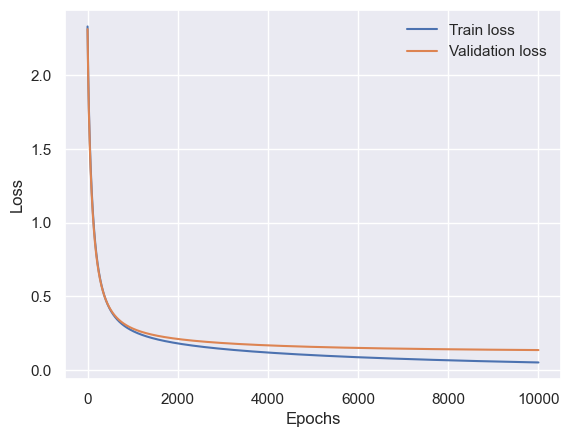

In [18]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

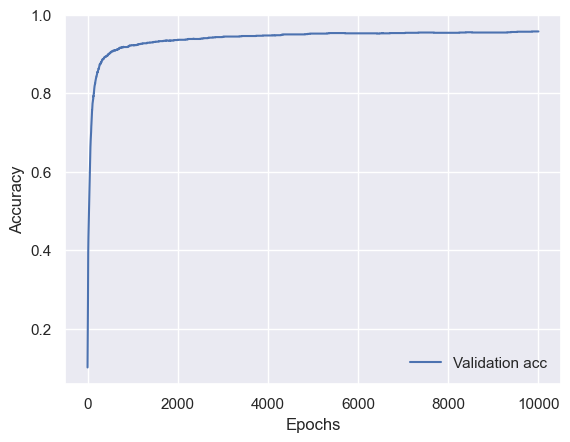

In [19]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, usps_test_x, usps_test_onehot_y))

Test acc : 0.9232685600398605


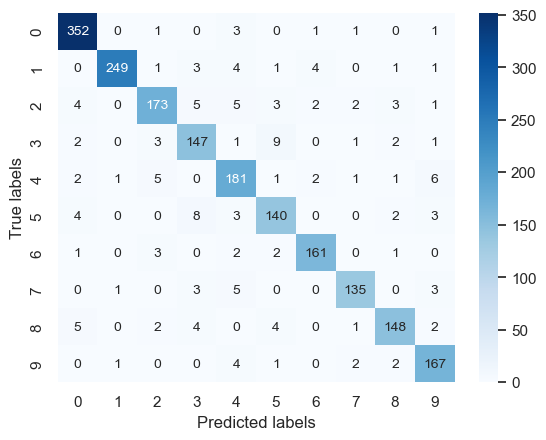

In [21]:
y_pred = net(usps_test_x).argmax(1)
y_test = usps_test_onehot_y.argmax(1)
cm = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g') # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#### Hidden layers dimension

In [14]:
hiddens = [10, 30, 50, 100, 200]

lr = 1e-2
n_epochs = 5_000

all_loss_ = []
all_loss_valid_ = []
all_acc_valid_ = []
all_acc_test_ = []

for hidden in hiddens:
    print('Hidden layers dimension :', hidden)
    net = Sequential(
        Linear(256, hidden),
        TanH(),
        Linear(hidden, hidden),
        TanH(),
        Linear(hidden, 10),
    )
    loss = CELoss()

    all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
        net,
        loss,
        lr,
        usps_train_x,
        usps_train_onehot_y,
        n_epochs,
        GradientDescentMode.BATCH,
        -1,
        eval_fn,
        usps_val_x,
        usps_val_onehot_y
    )

    net.set_parameters(best_parameters)
    acc_test = eval_fn(net, usps_test_x, usps_test_onehot_y)
    print('Test acc :', acc_test)

    all_loss_.append(all_loss)
    all_loss_valid_.append(all_loss_valid)
    all_acc_valid_.append(all_acc_valid)
    all_acc_test_.append(acc_test)
    print()

Hidden layers dimension : 10
Train : -----------------------------------
Epoch 500: train loss: 1.1402185684387764, validation loss: 1.1327677902103028, validation accuracy: 0.7518848526387937
Epoch 1000: train loss: 0.7829551339190326, validation loss: 0.794095421881954, validation accuracy: 0.8245373543522961
Epoch 1500: train loss: 0.5977305324603184, validation loss: 0.6234786730725703, validation accuracy: 0.8711446196024675
Epoch 2000: train loss: 0.48235882341661596, validation loss: 0.5198362857951419, validation accuracy: 0.8923920493488691
Epoch 2500: train loss: 0.4032154104800783, validation loss: 0.44975575651849015, validation accuracy: 0.8999314599040439
Epoch 3000: train loss: 0.3468617272382705, validation loss: 0.4011463793274469, validation accuracy: 0.9074708704592186
Epoch 3500: train loss: 0.3055119324264706, validation loss: 0.36709759957344934, validation accuracy: 0.9108978752570254
Epoch 4000: train loss: 0.2740196389583549, validation loss: 0.3425280769779855

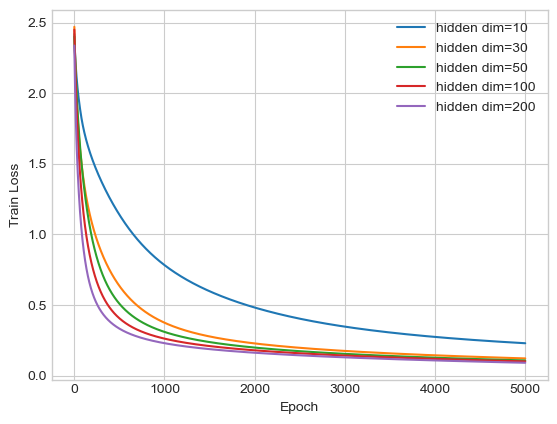

In [15]:
# hidden dim loss
plt.figure()
for i, hidden in enumerate(hiddens):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_[i], label=f'hidden dim={hidden}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

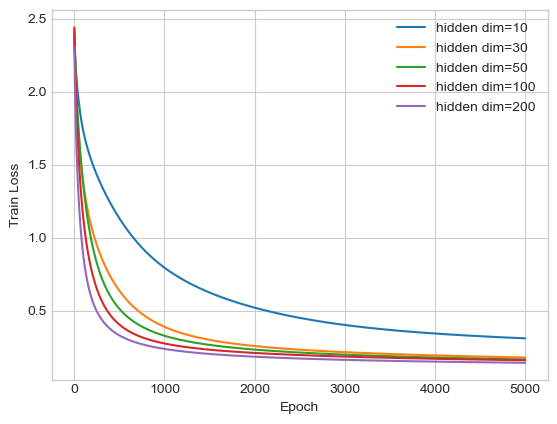

In [16]:
# hidden dim loss validation
plt.figure()
for i, hidden in enumerate(hiddens):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_valid_[i], label=f'hidden dim={hidden}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

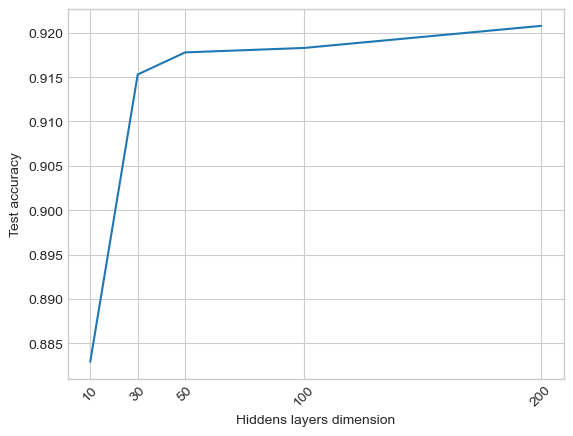

In [17]:
# hidden dim test accuracy
plt.figure()
plt.plot(hiddens, all_acc_test_)
plt.xlabel('Hiddens layers dimension')
plt.ylabel('Test accuracy')
plt.xticks(hiddens, rotation=45)
plt.show()